In [50]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D,  BatchNormalization,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf

In [51]:
# 文件路径设置
train_file = "./digital_recognizer/train.csv"  # 训练数据文件路径
test_file = "./digital_recognizer/test.csv"    # 测试数据文件路径
output_file = "submission.csv"     # 输出文件路径

## Load the data

In [52]:
# 从指定文件加载训练数据，skiprows=1 表示跳过第一行（通常为列名）
# dtype='int' 指定数据类型为整数，delimiter=',' 表示数据之间以逗号分隔
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
# 使用 train_test_split 函数将数据集拆分为训练集和验证集
# raw_data[:,1:] 表示特征数据，raw_data[:,0] 表示标签数据
# test_size=0.1 表示将 10% 的数据分配给验证集，90% 用于训练集
x_train, x_val, y_train, y_val = train_test_split(
    raw_data[:,1:], raw_data[:,0], test_size=0.1)

Text(0.5, 1.0, '28x28 data')

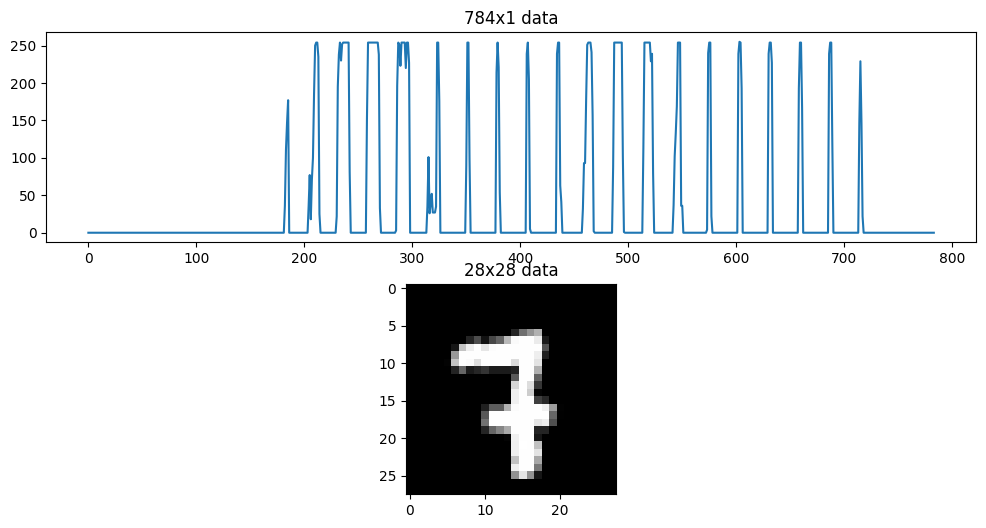

In [53]:
# 创建一个包含两个子图的图形，2 表示两行，1 表示一列
# figsize=(12,6) 设置图形的大小为宽12高6
fig, ax = plt.subplots(2, 1, figsize=(12,6))
# 在第一个子图(ax[0])中，绘制 x_train[0] 的折线图
ax[0].plot(x_train[0])
ax[0].set_title('784x1 data')# 设置第一个子图的标题
# 在第二个子图(ax[1])中，显示 x_train[0] 的灰度图像
# .reshape(28, 28) 将一维数据变形为 28x28 的矩阵
ax[1].imshow(x_train[0].reshape(28,28), cmap='gray')# 设置第二个子图的标题
# 显示图形
ax[1].set_title('28x28 data')

In [54]:
# 将 x_train 的形状变形为 (-1, 28, 28, 1)，其中 -1 表示自动推断，1 表示通道数为1（灰度图像）
# 然后再通过除以 255 进行归一化，将像素值缩放到 0 到 1 之间
x_train = (x_train.reshape(-1, 28, 28, 1)).astype("float32") / 255.
x_val = (x_val.reshape(-1, 28, 28, 1)).astype("float32") / 255.

In [55]:
#将标签转为独热编码形式
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#example:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [56]:
def create_cnn():
    model = Sequential()

    model.add(Conv2D(8, (3, 3), padding="same", input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (4, 4), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (4, 4), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])
    return model

In [57]:
#创建模型
model=create_cnn()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 8)         0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 14, 14, 8)         32        
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                      

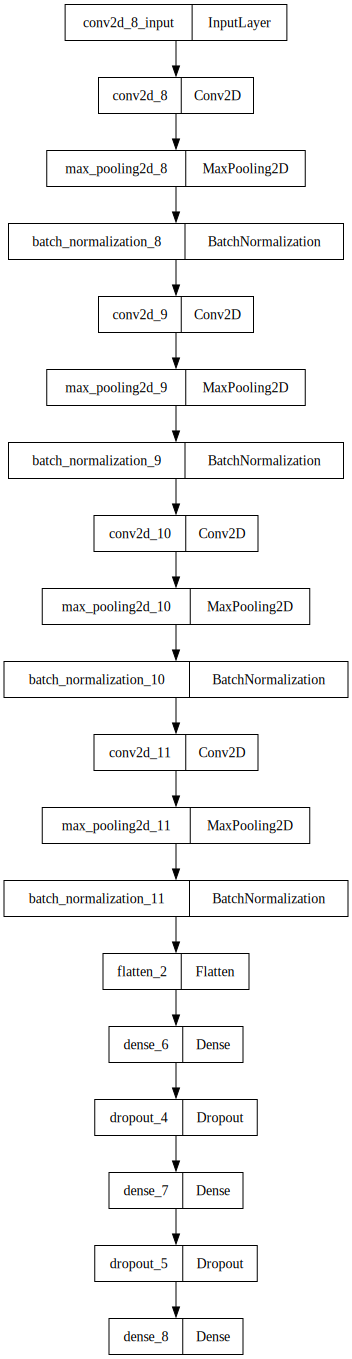

In [58]:
model.summary()
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
SVG(model_to_dot(model,dpi=72).create(prog='dot', format='svg'))

In [59]:
# 创建一个图像数据生成器（ImageDataGenerator）对象，进行数据增强
datagen = ImageDataGenerator(zoom_range = 0.1, # 随机缩放图像的范围，以便引入变焦效果
                            height_shift_range = 0.1, # 随机垂直平移图像的范围，引入高度方向的平移
                            width_shift_range = 0.1,  # 随机水平平移图像的范围，引入宽度方向的平移
                            rotation_range = 10)  # 随机旋转图像的范围，以度为单位

In [60]:
# 创建学习率调度器（LearningRateScheduler）对象
# 使用指数衰减函数 lambda x: 1e-3 * 0.9 ** x 调整学习率
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [61]:
# 使用 fit 函数进行模型训练
hist = model.fit(
    datagen.flow(x_train, y_train, batch_size=16),  # 使用数据生成器进行数据增强
    steps_per_epoch=500,                             # 每个 epoch 的步数，根据实际情况调整
    epochs=20,                                      # 训练的总 epoch 数
    verbose=2,                                      # 控制输出信息的详细程度，2 表示每个 epoch 输出一行信息
    validation_data=(x_val[:400, :], y_val[:400, :]),  # 验证集数据，用于在训练过程中评估模型性能
    callbacks=[annealer]                             # 使用学习率调度器作为回调函数
)

Epoch 1/20
500/500 - 7s - loss: 0.5988 - acc: 0.8041 - val_loss: 0.1914 - val_acc: 0.9400 - lr: 0.0010 - 7s/epoch - 14ms/step
Epoch 2/20
500/500 - 3s - loss: 0.2624 - acc: 0.9208 - val_loss: 0.1940 - val_acc: 0.9450 - lr: 9.0000e-04 - 3s/epoch - 7ms/step
Epoch 3/20
500/500 - 4s - loss: 0.2144 - acc: 0.9367 - val_loss: 0.0993 - val_acc: 0.9675 - lr: 8.1000e-04 - 4s/epoch - 7ms/step
Epoch 4/20
500/500 - 4s - loss: 0.1704 - acc: 0.9489 - val_loss: 0.0440 - val_acc: 0.9850 - lr: 7.2900e-04 - 4s/epoch - 7ms/step
Epoch 5/20
500/500 - 4s - loss: 0.1515 - acc: 0.9565 - val_loss: 0.1483 - val_acc: 0.9675 - lr: 6.5610e-04 - 4s/epoch - 7ms/step
Epoch 6/20
500/500 - 3s - loss: 0.1449 - acc: 0.9560 - val_loss: 0.0503 - val_acc: 0.9825 - lr: 5.9049e-04 - 3s/epoch - 7ms/step
Epoch 7/20
500/500 - 3s - loss: 0.1217 - acc: 0.9625 - val_loss: 0.0730 - val_acc: 0.9825 - lr: 5.3144e-04 - 3s/epoch - 7ms/step
Epoch 8/20
500/500 - 3s - loss: 0.1120 - acc: 0.9671 - val_loss: 0.0742 - val_acc: 0.9775 - lr: 4.78

## Evaluate

In [62]:
# 使用 evaluate 函数评估模型在验证集上的性能
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
# 输出最终的损失值和准确率
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0384, final accuracy: 0.9905


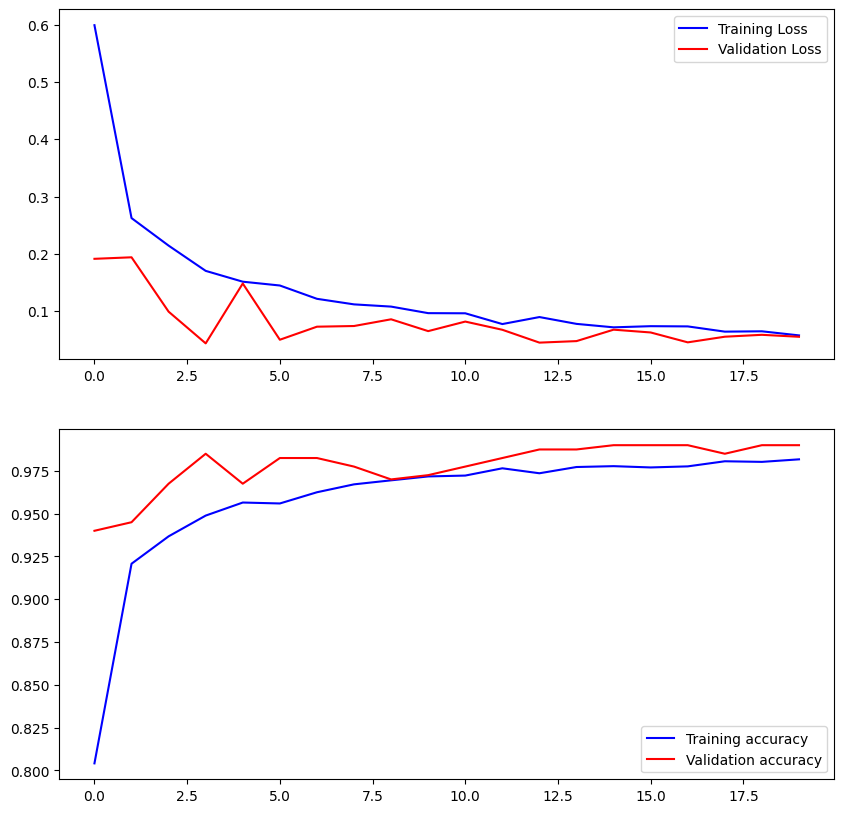

In [63]:
f,ax=plt.subplots(2,1,figsize=(10,10))
# 绘制训练集和验证集的损失曲线
ax[0].plot(hist.history['loss'], color='b',label='Training Loss')
ax[0].plot(hist.history['val_loss'], color='r',label='Validation Loss')
ax[0].legend()
# 绘制训练集和验证集的准确率曲线
ax[1].plot(hist.history['acc'], color='b',label='Training accuracy')
ax[1].plot(hist.history['val_acc'], color='r',label='Validation accuracy')
ax[1].legend()
plt.show()

In [64]:
# 使用模型对验证集进行预测
y_hat = model.predict(x_val)
# 从预测结果中取最大值所在的索引，得到预测类别
y_pred = np.argmax(y_hat, axis=1)
# 从验证集的真实标签中取最大值所在的索引，得到真实类别
y_true = np.argmax(y_val, axis=1)
# 使用混淆矩阵评估模型性能
cm = confusion_matrix(y_true, y_pred)
# 输出混淆矩阵
print(cm)

132/132 [==============================] - 0s 2ms/step
[[418   0   0   0   0   0   0   0   1   0]
 [  0 434   1   0   1   0   0   1   0   0]
 [  0   0 416   0   0   0   0   0   0   0]
 [  0   0   1 446   0   1   0   0   0   0]
 [  0   0   0   0 406   0   0   2   2   2]
 [  0   0   0   0   0 399   0   0   2   1]
 [  0   0   0   0   2   3 421   0   0   0]
 [  0   0   1   0   2   0   0 419   0   0]
 [  0   1   0   0   0   1   1   0 390   0]
 [  2   0   0   1   3   1   0   1   6 411]]


In [65]:
# 使用 classification_report 函数生成分类报告
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       419
           1       1.00      0.99      1.00       437
           2       0.99      1.00      1.00       416
           3       1.00      1.00      1.00       448
           4       0.98      0.99      0.98       412
           5       0.99      0.99      0.99       402
           6       1.00      0.99      0.99       426
           7       0.99      0.99      0.99       422
           8       0.97      0.99      0.98       393
           9       0.99      0.97      0.98       425

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



In [66]:
def plot_test_images(images, y_pred):
    """
    绘制测试集图像及其对应的预测标签。
    参数:
    - images: 包含图像数据的列表或数组
    - y_pred: 模型的预测标签列表
    注意：假设图像是灰度图。
    """
    plt.figure(figsize=(10, 10))
    for i in range(min(25, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i][:, :, 0], cmap='gray')  # Assuming images are grayscale
        plt.axis('off')
        plt.title(f"Predicted: {y_pred[i]}")
    plt.show()
    return

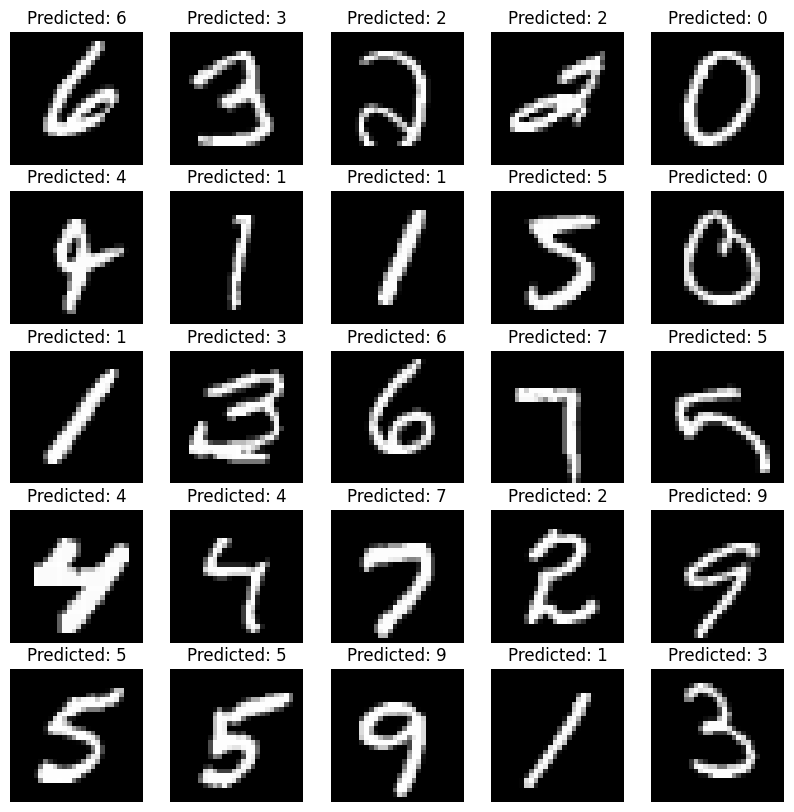

In [67]:
plot_test_images(x_val,y_pred)

In [68]:
# 从文件中加载 MNIST 测试集数据
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
# 将数据类型转换为 float32
x_test = mnist_testset.astype("float32")
#调整大小，像素归一化
x_test = x_test.reshape(-1, 28, 28, 1)/255.

In [69]:
#进行测试集的预测
y_hat = model.predict(x_test, batch_size=64)

438/438 [==============================] - 1s 2ms/step


In [70]:
#找到每个样本预测结果中的最大值所在的索引
y_pred = np.argmax(y_hat,axis=1)

In [71]:
#创建比赛需要的预测结果文件
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))